<center>
<div style="max-width:400px;">
    
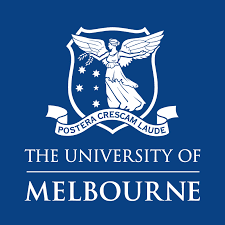

</div>
</center>

# Multiple Regression

**Prof. Kevin Otto and Nikolas Crossan**  
The University of Melbourne  
Department of Mechanical Engineering

----------------------------------------------------------------------------

This notebook demonstrates ordinary least squares regression of multiple variables.  The example considered is a simple AHRI compressor map fit of compressor capacity versus saturation and discharge temperature variables.  

This notebook relies on the `mqrpy` code library, found at https://pypi.org/project/mqrpy/


In [1]:
import mqr
from mqr.plot import Figure
from mqr.nbtools import hstack, vstack, grab_figure, Line

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from statsmodels.formula.api import ols

from importlib.metadata import version
print('MQR version', version('mqrpy'))
print('Numpy version', version('numpy'))
print('Scipy version', version('scipy'))
print('Pandas version', version('pandas'))

MQR version 0.6.0
Numpy version 1.26.4
Scipy version 1.13.1
Pandas version 2.2.2


Create a Pandas dataframe with the compressor map test data values.  

In [2]:
data = {'Ts':[45.0,45.0,45.0,45.0,45.0,45.0,
              50.0,50.0,50.0,50.0,50.0,50.0,
              55.0,55.0,55.0,55.0,55.0,55.0],
        'Td':[90.0,94.0,100.0,106.0,114.0,120.0,
              90.0,94.0,100.0,106.0,114.0,120.0,
              90.0,94.0,100.0,106.0,114.0,120.0],
        'Capacity':[40754.0,40274.0,38591.0,37327.0,35442.0,33474.0,
                    45019.0,43801.0,42943.0,40979.0,38484.0,37161.0,
                    49478.0,47984.0,46465.0,44895.0,42827.0,41471.0]}
df = pd.DataFrame(data)
df.head()

,Ts,Td,Capacity
0,45.0,90.0,40754.0
1,45.0,94.0,40274.0
2,45.0,100.0,38591.0
3,45.0,106.0,37327.0
4,45.0,114.0,35442.0


Fit a regression equation using all terms up to order 3.  

In [3]:
form = '''
    Capacity ~
    Ts + Td +
    I(Ts**2) + I(Ts * Td) + I(Td**2) +
    I(Ts**3) + I(Ts**2 * Td) + I(Ts * Td**2) + I(Td**3)
'''
mod = ols(form, df)
res = mod.fit()

vstack(
   '#### Summary Statistics',
    mqr.anova.adequacy(res),
   '#### Regression Table',
    mqr.anova.coeffs(res),
)

/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Notice the warning, the input matrix is highly singular. It is surprising that any result even calculated without a divide by zero.  Also notice many terms have very high VIFs, indicating they are correlated with other inputs.  

Next check which inputs are correlated by computing the correlation matrix of the terms.

<Axes: >

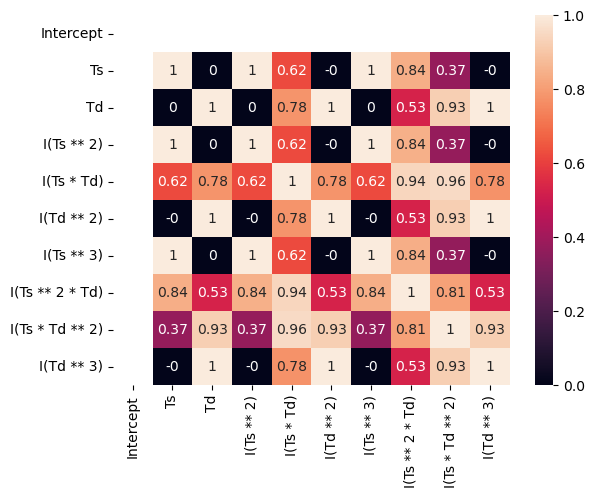

In [4]:
corr = pd.DataFrame(mod.exog, columns=mod.exog_names).corr()
sns.heatmap(corr, annot=np.round(corr, 3))

There are several highly correlated variables, notable Ts with its higher order terms and Td with its higher order terms.  Let's progressively drop them in order of p-value rank.  Start by dropping the correlated high order Td terms.

In [5]:
form = '''
    Capacity ~
    Ts + Td +
    I(Ts**2) + I(Ts * Td) +
    I(Ts**3) + I(Ts**2 * Td) + I(Ts * Td**2)
'''
# Dropped the Td**3 term

mod = ols(form, df)
res = mod.fit()

vstack(
    mqr.anova.adequacy(res),
    mqr.anova.coeffs(res),
)

/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
/opt/anaconda3/envs/mcen90059/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Now drop the Ts higher order terms.

In [6]:
form = '''
    Capacity ~
    Ts + Td +
    I(Ts * Td) +
    I(Ts**2 * Td) + I(Ts * Td**2)
'''
# Dropped the Td**3 Ts**3 terms

mod = ols(form, df)
res = mod.fit()

vstack(
    mqr.anova.adequacy(res),
    mqr.anova.coeffs(res),
)

Now the TsTd2 term has worst p-value, drop it.

In [7]:
form = '''
    Capacity ~
    Ts + Td +
    I(Ts * Td) +
    I(Ts**2 * Td)
'''
# Dropped the Td**3 Ts**3 Ts*Td*Td terms

mod = ols(form, df)
res = mod.fit()

vstack(
    mqr.anova.adequacy(res),
    mqr.anova.coeffs(res),
)

Do not drop linear terms unless all higher order terms also are dropped.  Therefore next drop the Ts2Td term. 

In [8]:
form = '''
    Capacity ~
    Ts + Td +
    I(Ts * Td)
'''
# Dropped the Td**3 Ts**3 Ts*Td*Td Ts*Td*Td terms
mod = ols(form, df)
res = mod.fit()

vstack(
    mqr.anova.adequacy(res),
    mqr.anova.coeffs(res))

Now drop the TsTd terms, given its high p-value.

In [9]:
form = '''
    Capacity ~
    Ts + Td
'''
mod = ols(form, df)
res = mod.fit()

vstack(
    mqr.anova.adequacy(res),
    mqr.anova.coeffs(res),
)

Now all that remains is the linear terms.  All the higher order polynomials did nothing.  

### Residual Analysis

Show the residuals plots and their distribution statistics.


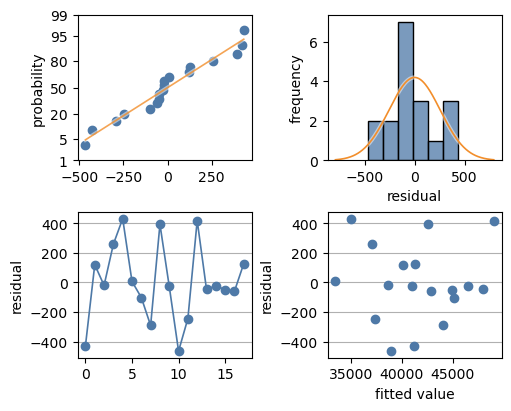

In [10]:
with Figure(5, 4, 2, 2) as (fig, ax):
    mqr.plot.regression.residuals(res.resid, res.fittedvalues, axs=ax)
    plot = grab_figure(fig)

hstack(
    plot,
    mqr.inference.dist.test_1sample(res.resid)
)

We see some structure remains in the normal distribution plot and in the residual vs fitted value plot.  These won't go away with higher order terms, though they might with a transformation of variables, which is beyond this subject. 